In [2]:
import struct
import numpy as np

In [3]:
train_data = "./data/train-images.idx3-ubyte"
train_data_label = "./data/train-labels.idx1-ubyte"
test_data = "./data/t10k-images.idx3-ubyte"
test_data_label = "./data/t10k-labels.idx1-ubyte"

with open(train_data,'rb') as trdata:
    _, train_number, row, col = struct.unpack('>IIII', trdata.read(16))
    train_images = np.fromfile(trdata, dtype=np.uint8).reshape(train_number,row,col,1)

with open(train_data_label, 'rb') as trlabel:
    _, train_lable_number = struct.unpack('>II',trlabel.read(8))
    train_labels = np.fromfile(trlabel, dtype=np.uint8)

with open(test_data,'rb') as testdata:
    _, test_number, row, col = struct.unpack('>IIII', testdata.read(16))
    test_images = np.fromfile(testdata, dtype=np.uint8).reshape(test_number,row,col,1)

with open(test_data_label, 'rb') as testlabel:
    _, test_lable_number = struct.unpack('>II',testlabel.read(8))
    test_labels = np.fromfile(testlabel, dtype=np.uint8)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use('fivethirtyeight')

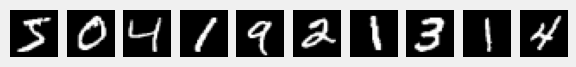

In [5]:
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(train_images[i],cmap='gray')
    ax[i].axis('off')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize

In [7]:
mean = torch.tensor(0.1307)
std = torch.tensor(0.3081)
compose = Compose([ToTensor(), Normalize(mean,std)])

In [9]:
class TransformTensorDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __getitem__(self, index):
        X = self.X[index]
        if self.transform:
            X = self.transform(X)
        return X, self.y[index]
    
    def __len__(self):
        return len(self.X)


In [10]:
train_images_Dataset = TransformTensorDataset(train_images, train_labels, transform=compose)
test_images_Dataset = TransformTensorDataset(test_images, test_labels, transform=compose)
train_loader = DataLoader(train_images_Dataset, batch_size=10000, shuffle=True)
test_loader = DataLoader(test_images_Dataset, batch_size=2000)

In [5]:
from torchvision import datasets

mean = torch.tensor(0.1307)
std = torch.tensor(0.3081)
compose = Compose([ToTensor(), Normalize(mean,std)])
train_dataset = datasets.MNIST('./data', train=True, transform=compose, download=False)
test_dataset =  datasets.MNIST('./data', train=False, transform=compose, download=False)
train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2000)

In [11]:
class ImageShallowModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28,10)
        
    def forward(self, x):
        x=self.flatten(x)
        return self.linear(x)
       

In [12]:
def mini_batch_train(data_loader,model,optimizer,loss_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        # 置为训练状态
        model.train()
        # Step 1 - 前向计算预测值
        yhat = model(x_batch)
        # Step 2 - 计算损失
        mini_batch_loss = loss_fn(yhat, y_batch)
        # Step 3 - 计算梯度
        mini_batch_loss.backward()
        # Step 4 - 参数更新
        optimizer.step()
        optimizer.zero_grad()

        mini_batch_losses.append(mini_batch_loss.item())
                  
    loss = np.mean(mini_batch_losses)
    return loss

In [13]:
def mini_batch_val(data_loader,model,loss_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        # 置为验证状态
        model.eval()
        # Step 1 - 前向计算预测值
        yhat = model(x_batch)
        # Step 2 - 计算损失
        mini_batch_loss = loss_fn(yhat, y_batch)
        mini_batch_losses.append(mini_batch_loss.item())
                  
    loss = np.mean(mini_batch_losses)
    return loss

In [14]:
def train(model, train_loader, test_loader, loss_fn, optimizer, epochs):
    # 指定随机数种子，可以再现数据
    np.random.seed(23)
    torch.manual_seed(23)

    # 循环轮数计数
    total_epochs = 0

    losses = []  # 每轮训练的损失
    val_losses = [] #  每轮验证数据的损失

    for epoch in range(epochs):
        model.train()
        total_epochs += 1

        # 进入mini-batch的内循环
        loss = mini_batch_train(train_loader,model,optimizer,loss_fn)
        losses.append(loss)

        # 验证数据集（验证不需要计算梯度）
        with torch.no_grad():
            # 验证集的 mini_batch
            val_loss = mini_batch_val(test_loader,model,loss_fn)
            val_losses.append(val_loss)
    
    return losses, val_losses

In [15]:
model = ImageShallowModel()
lr = 3e-3
epochs = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss, val_loss = train(model, train_loader, test_loader, loss_fn, optimizer, epochs)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.style.use('fivethirtyeight')
def plot_losses():
    fig = plt.figure(figsize=(10, 4))
    plt.plot(train_loss, label='Training Loss', c='b')
    plt.plot(val_loss, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

fig=plot_losses()

In [16]:
def correct(model, x, y):
        model.eval()
        yhat = model(x)
        _, predicted = torch.max(yhat, 1)
        n_samples, n_dims = yhat.shape
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        
        return torch.tensor(result)

In [17]:
results = [correct(model, x, y) for i, (x, y) in enumerate(test_loader)]
results = torch.stack(results, axis=0)
results = results.sum(axis=0)

In [19]:
results.sum(axis=0)


tensor([ 9237, 10000])